# 1. Dataset Introduction

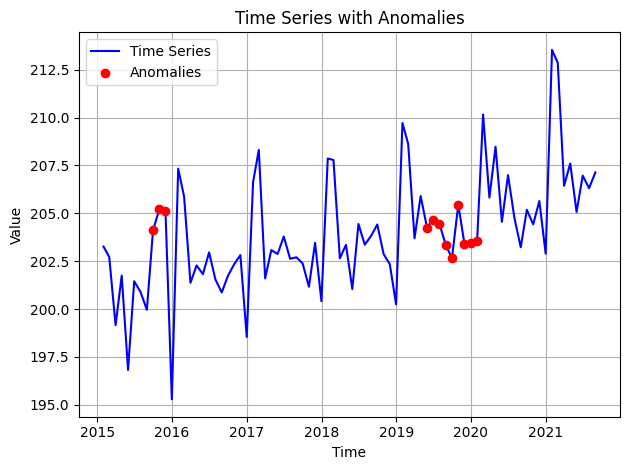

In [ ]:
from tools.tools import *
from data.synthetic.tools.residuals import *
from data.synthetic.data_set import *
from visualization.line_plot import *
from models.statistical.rule_based_functions import *
from models.statistical.stationary_models import *

from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

set_global_seed(0)


# Load data
df = get_ts_1()
ts = df['value']

plot_data_with_anom(df)

# 2. Preprocessing & Exploratory Analysis

# 3. Model Selection & Fitting

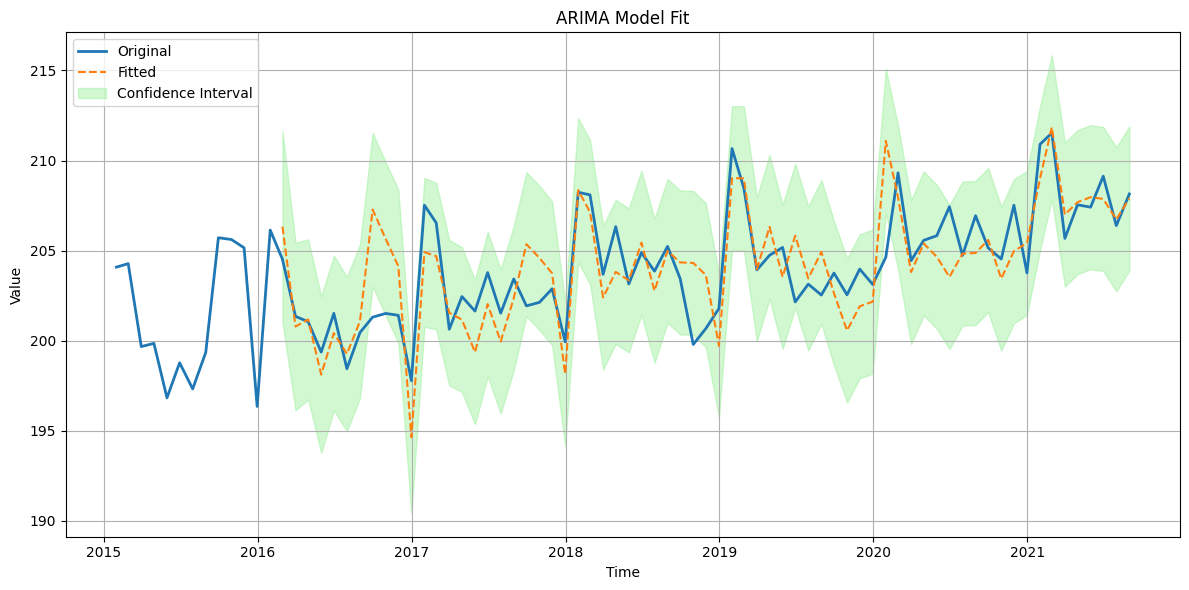

In [32]:
# Model fitting
model = SARIMAX(ts, order=(0, 1, 1), seasonal_order=(1, 1, 0, 12))
model_fit = model.fit()
fitted_vals = model_fit.fittedvalues[13:]
resid = ts - fitted_vals

# Get Prediction and CI
pred = model_fit.get_prediction(start=13, alpha=0.05)
conf_int = pred.conf_int()

# Plot time series
plot_fit(ts, fitted_vals, CI=conf_int)

Rule based Anomaly detection

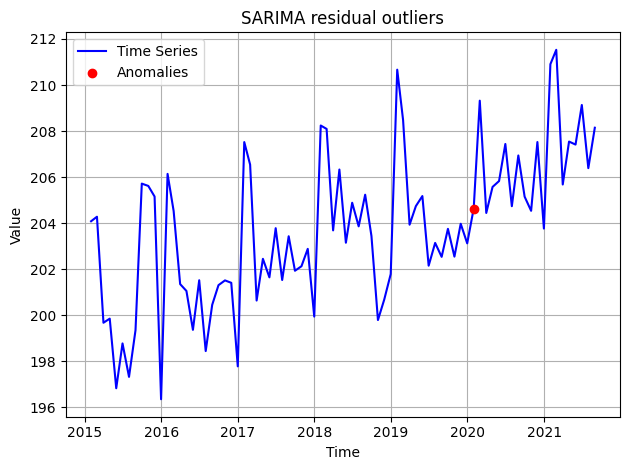

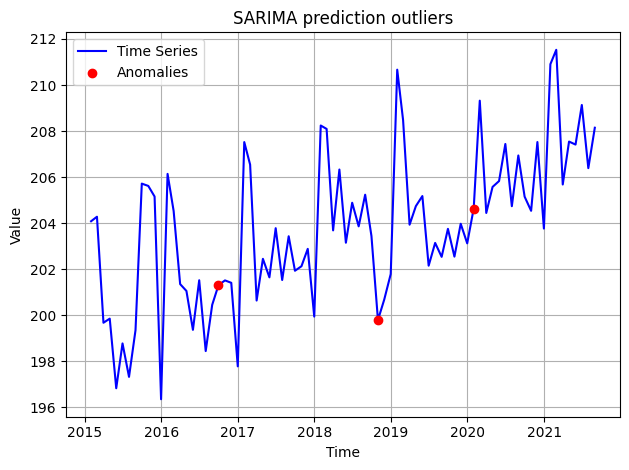

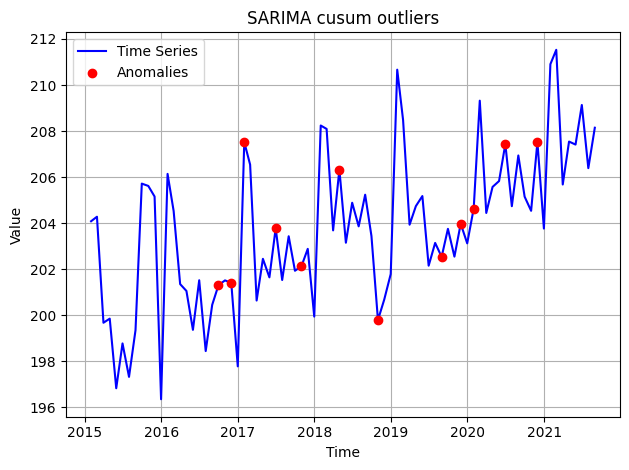

In [33]:
anoms_resid = get_residual_outliers(resid)
plot_ts_with_anom(ts, anoms_resid, title='SARIMA residual outliers')

anoms_outlier = get_prediction_outliers(ts, model_fit)
plot_ts_with_anom(ts, anoms_outlier, title='SARIMA prediction outliers')

anoms_cusum = cusum(resid)
plot_ts_with_anom(ts, anoms_cusum, title='SARIMA cusum outliers')

Baysian methods

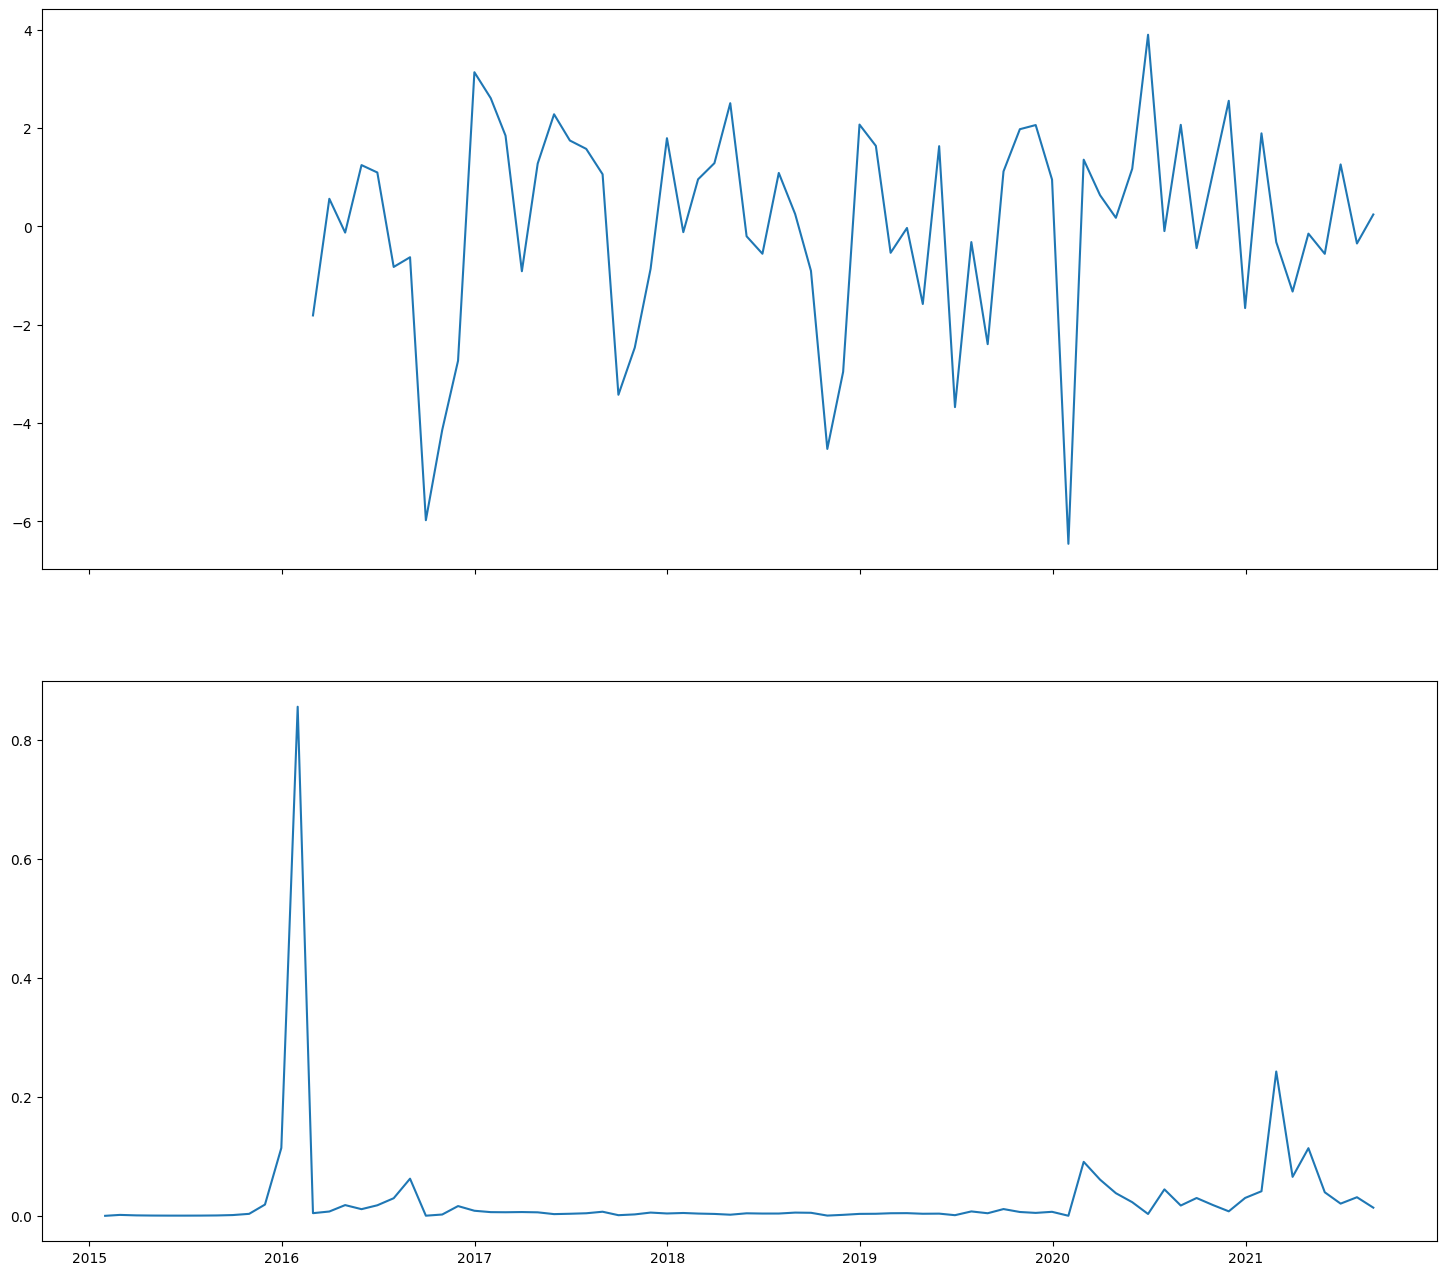

In [34]:
from bayesian_changepoint_detection.priors import const_prior
from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection
import bayesian_changepoint_detection.offline_likelihoods as offline_ll
from functools import partial

prior_function = partial(const_prior, p=1/(len(resid) + 1))

Q, P, Pcp = offline_changepoint_detection(resid, prior_function ,offline_ll.StudentT(),truncate=-10)
values = np.insert(np.exp(Pcp).sum(0), 0, 0)
values = pd.Series(values.flatten(), index=resid.index)
# Pcp = 

fig, ax = plt.subplots(2, figsize=[18, 16], sharex=True)
ax[0].plot(resid[:])
ax[1].plot(values)

Kalman Filters

In [35]:
from pykalman import KalmanFilter
from scipy.stats import chi2

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
kf = kf.em(ts.values, n_iter=10) 

filtered_state_means, filtered_state_covariances = kf.filter(ts.values)

print(filtered_state_means)
print(filtered_state_covariances)

predicted_means, predicted_covs = kf.filter_update(
    filtered_state_means[:-1], filtered_state_covariances[:-1], observation=ts.values[1:]
)

predicted_means = np.insert(predicted_means, 0, filtered_state_means[0])
predicted_covs = np.insert(predicted_covs, 0, filtered_state_covariances[0], axis=0)
std_devs = np.sqrt(np.squeeze(predicted_covs))

residuals = ts.values - predicted_means
nis = (residuals ** 2) / (std_devs ** 2)

# Chi-square cutoff for anomaly detection
cutoff = chi2.ppf(1, df=1)
is_anomaly = nis > cutoff

# Return anomalies as Series aligned to original index
anomalies = pd.Series(is_anomaly, index=ts.index)
filtered_series = pd.Series(filtered_state_means.flatten(), index=ts.index)

plt.plot(ts, label='Observations', alpha=0.5)
plt.plot(filtered_series, label='Kalman Filter Estimate')
plt.legend()
plt.show()


[[129.88618307]
 [153.0320689 ]
 [173.17837871]
 [185.67357018]
 [191.0139883 ]
 [194.75120809]
 [195.99361181]
 [197.61438693]
 [201.52241839]
 [203.49777619]
 [204.29872819]
 [200.46887325]
 [203.20430836]
 [203.84280293]
 [202.64374363]
 [201.87962055]
 [200.6697742 ]
 [201.08137052]
 [199.81205609]
 [200.1226398 ]
 [200.69531916]
 [201.0916235 ]
 [201.24613487]
 [199.57702556]
 [203.40812265]
 [204.91965399]
 [202.85721761]
 [202.66262097]
 [202.17390464]
 [202.95035954]
 [202.26773363]
 [202.82959177]
 [202.39866904]
 [202.27023841]
 [202.56743581]
 [201.30334997]
 [204.64934944]
 [206.31041688]
 [205.04610506]
 [205.66560968]
 [204.45402776]
 [204.66354065]
 [204.2776506 ]
 [204.74073388]
 [204.11578277]
 [202.03247474]
 [201.38241695]
 [201.58020175]
 [205.96176072]
 [207.17450487]
 [205.61237918]
 [205.19281566]
 [205.18618208]
 [203.72458022]
 [203.44453826]
 [203.00810389]
 [203.36860841]
 [202.97329732]
 [203.45697051]
 [203.29719091]
 [203.94348013]
 [206.53641781]
 [205.52

ValueError: shapes (1,1) and (79,1) not aligned: 1 (dim 1) != 79 (dim 0)